<h1>Klasifikasi Dokumen Berita BBC</h1>

Proyek ini bertujuan untuk mengklasifikasikan dokumen menggunakan Jaringan Saraf Tiruan (JST) (<i>Artificial Neural Network (ANN)</i>). Pada proyek ini kami juga akan menggunakan algoritma non JST yaitu : KNN sebagai metode pembanding. Score TF-IDF akan digunakan sebagai fitur dalam proyek ini, yang dimana selanjutnya dijadikan input untuk jaringan Saraf Tiruan. Dari proses training ini diharapkan mampu menghasilkan model yang handal dalam melakukan klasifikasi dokumen. Adapun alur proyek yang diadaptasikan dalam proyek ini adalah sebagai berikut :
<ol>
  <li>Load Dataset</li>
  <li>Preprocessing Data</li>
    <ul>
      <li>Lowercasing</li>
      <li>Tokenisasi</li>
      <li>Cleaning</li>
      <li>Stopword</li>
      <li>Steming</li>
      <li>Lematisasi</li>
      <li>Data Spliting</li>
    </ul>
  <li>Features Reduction(Optional)</li>
    <ul>
      <li>PCA</li>
      <li>Chi-Square</li>
    </ul>
  <li>Training Phase</li>
    <ul>
      <li>Backpropagation</li>
      <li>RNN</li>
      <li>KNN</li>
    </ul>
  <li>Testing Phase</li>
  <li>Result</li>
    <ul>
      <li>Confusion Matrix</li>
      <li>Accuracy</li>
      <li>Precision</li>
      <li>Recall</li>
      <li>F1 Score</li>
    </ul>
</ol>

<h2>Load Dataset</h2>

Dataset yang digunakan adalah <a href ="https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification">BBC Full Text Document Classification</a>. Dataset ini terdiri atas 2225 dokumen yang dikurasi dari website berita BBC dengan 5 kategori (bussines, entertainment, politics, sport dan tech). Dataset ini dikurasi dari tahun 2004 - 2005.

Sitasi : D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

In [61]:
# Data manipulation libraries.
import numpy as np
import pandas as pd
import spacy

# Data visualization libraries.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# General Imports
import os
import re
from tqdm import tqdm
from colorama import Fore, Style
from collections import Counter
import string

import re
#-------NLTK--------------
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
# from unidecode import unidecode
# from contractions import fix
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from wordcloud import WordCloud


from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV


from sklearn.cluster import KMeans , AgglomerativeClustering, DBSCAN
# from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer,ClusteringScoreVisualizer
from sklearn.metrics import silhouette_score

# Library versions.
# print("NumPy version:", np.__version__)
# print("Spacy version:", spacy.__version__)
# print("Pandas version:", pd.__version__)
# print("Matplotlib version:", matplotlib.__version__)
# print("Seaborn version:", sns.__version__)

NumPy version: 1.26.0
Spacy version: 3.7.1
Pandas version: 2.1.1
Matplotlib version: 3.8.0
Seaborn version: 0.13.0


<h3>Konstanta</h3>

In [28]:
DATA_DIR = "dataset/"
METADATA_CSV = "doc_metadata.csv"
PARSED_TEXT_CSV = "doc_parsed_text1.csv"
FINAL_CSV = "doc_preprocessed.csv"
SPECIAL_CHARS = r"([^a-z0-9\s])\1+"

<h3>Daftar Fungsi</h3>

In [11]:
def display_as_table(headers, rows, align="r", add_sl_no=False):
    if isinstance(rows, pd.Series):
        rows = list(rows.iteritems())

    table = PrettyTable(align=align)

    if add_sl_no:
        table.field_names = ["No."] + list(headers)
        table.align["No."] = "r"
        rows = [[idx + 1] + list(row) for idx, row in enumerate(rows)]
    else:
        table.field_names = headers

    table.add_rows(rows)
    display(table)


to_dict = lambda frm_list: {item: frm_list.index(item) for item in frm_list}

def plot_elbow(ll, hl, col_name, df, y_label):
    plt.figure(figsize=(4, 3))

    pts = df[col_name].quantile(q=np.arange(ll, hl, 0.01))
    sns.lineplot(x=pts.index, y=pts)
    plt.title(f"{y_label} b/w {ll} & {round(hl - 0.01, 2)} percentile")
    plt.xlabel("Percentile")
    plt.ylabel(y_label)

    plt.show()
    
def is_empty(element):
    """
    Function to check if input element is empty.
    """

    if (isinstance(element, int) or isinstance(element, float)) and element == 0:
        # Exclude 0 and 0.0 from the Falsy set.
        return False
    elif isinstance(element, str) and len(element.strip()) == 0:
        # Include string with only one or more empty space(s) into Falsy set.
        return True
    elif isinstance(element, bool):
        # Exclude False from the Falsy set.
        return False
    else:
        return False if element else True

def generate_wordcloud(data,column):
    str_text=data[column].str.cat(sep=" ")    # we have to convert all review into single string
    wordcloud=WordCloud(width=500,height=300,background_color='white').generate(str_text)
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


stopwords_list = stopwords.words('english')
len(stopwords_list)

flags_im = re.IGNORECASE | re.MULTILINE

def preprocess_data(text):
    text = text.lower()
    text = re.sub(SPECIAL_CHARS, " ", text, flags=flags_im)
    text = text.replace("\n"," ").replace("\t"," ")
    text = re.sub("\s+"," ",text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # modul 're' (regex) 
    # semua angka dalam teks diganti dengan string kosong, sehingga dihapus dari teks
    text = re.sub(r"\d+", "", text)

    # menghapus spasi kosong di awal dan akhir teks
    text = text.strip()

    # mencocokkan kata-kata yang mengandung angka, semua kata-kata semacam itu diganti dengan string kosong
    text = re.sub('\w*\d\w*', '', text)

    # mencocokkan tag HTML dan konten di dalamnya, semua tag HTML diganti dengan string kosong
    text = re.sub('<.*?>+', '', text)

    # mencocokkan teks yang ada di antara kurung siku, semua teks dalam kurung siku diganti dengan string kosong
    text = re.sub('\[.*?\]', '', text)

    # mencocokkan URL dengan atau tanpa protokol HTTP(S) dan URL tanpa protokol, semua URL diganti dengan string kosong
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # berisi semua karakter tanda baca, semua tanda baca dalam teks diganti dengan string kosong
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # mengganti semua karakter newline (\n) dengan spasi kosong, sehingga baris-baris baru dihapus
    text = text.replace("\n"," ")

    # mengganti dua spasi kosong berturut-turut dengan satu spasi kosong
    text = text.replace("  "," ")
    
    # tokens
    tokens = word_tokenize(text)
    
    data = [i for i in tokens if i not in punctuation]
    data = [i for i in data if i not in stopwords_list]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    final_text = []
    for i in data:
        word = lemmatizer.lemmatize(i)
        final_text.append(word)
        
    return " ".join(final_text)

In [38]:
if os.path.exists(METADATA_CSV):
    print("Loading metadata from:", METADATA_CSV)
    meta_df = pd.read_csv(METADATA_CSV)
else:
    meta_data = []

    folder_kategori = os.listdir(DATA_DIR)

    for kategori in folder_kategori:
        path_kategori = os.path.join(DATA_DIR, kategori)
        if not os.path.isdir(path_kategori):
            continue

        nama_docs = os.listdir(path_kategori)
        for doc in nama_docs:
            path_doc = path_kategori + "/" + doc
            ukuran_doc = os.path.getsize(path_doc)
            nama_doc, ext = os.path.splitext(doc) 
            doc_id = kategori[0].upper() + "_" + nama_doc
            meta_data.append([kategori.capitalize(), doc_id, ukuran_doc, path_doc])

    nama_kolom = ["Doc_Kategori", "Id_Doc", "Ukuran_Doc", "Path_Doc"]
    meta_df = pd.DataFrame(data=meta_data, columns=nama_kolom)

    meta_df.to_csv(METADATA_CSV, index=False, na_rep="")

meta_df["Doc_Kategori"] = meta_df["Doc_Kategori"].astype("category")

meta_df.sample(10)


Loading metadata from: doc_metadata.csv


,Doc_Kategori,Id_Doc,Ukuran_Doc,Path_Doc
1401,Business,B_486,1821,dataset/business/486.txt
1718,Sport,S_486,2380,dataset/sport/486.txt
2043,Sport,S_205,2178,dataset/sport/205.txt
1613,Business,B_095,1568,dataset/business/095.txt
1463,Business,B_259,1435,dataset/business/259.txt
1489,Business,B_285,1514,dataset/business/285.txt
894,Entertainment,E_250,1421,dataset/entertainment/250.txt
146,Tech,T_271,1704,dataset/tech/271.txt
291,Tech,T_219,1937,dataset/tech/219.txt
108,Tech,T_303,1678,dataset/tech/303.txt


Info Dataframe

In [33]:
baris, kolom = meta_df.shape
print(f"Dataset terdiri dari {baris} baris and {kolom} kolom.\n")

meta_df.info()

Dataset terdiri dari 2225 baris and 4 kolom.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Doc_Kategori  2225 non-null   category
 1   Id_Doc        2225 non-null   object  
 2   Ukuran_Doc    2225 non-null   int64   
 3   Path_Doc      2225 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 54.7+ KB


Tidak ada data yang <i>missing</i>

<h3>Label Kategori</h3>

In [12]:
jum_kategori = meta_df["Doc_Kategori"].value_counts()

display_as_table(
  headers = ["Label Kategori", "Jumlah"],
  rows = list(zip(jum_kategori.index, jum_kategori.values)),
  add_sl_no = True
)

No.,Label Kategori,Jumlah
1,Sport,511
2,Business,510
3,Politics,417
4,Tech,401
5,Entertainment,386


<h3>Plot Data Berdasarkan Kategori</h3>

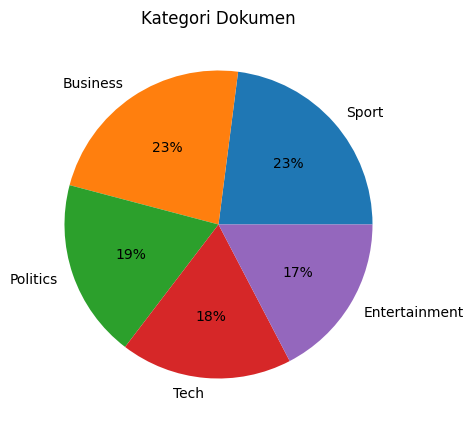

In [13]:
plt.figure(figsize=(5, 5))

plt.pie(x=jum_kategori, labels=jum_kategori.index, autopct="%1.0f%%")
plt.title("Kategori Dokumen")

plt.show()

In [41]:
codes, uniques = pd.factorize(meta_df["Doc_Kategori"])

cls_map = to_dict(uniques.categories.to_list())
print("Encoded class-labels:\n", cls_map)

meta_df["Doc_Label"] = codes
meta_df["Doc_Label"].value_counts().sort_index()

Encoded class-labels:
 {'Business': 0, 'Entertainment': 1, 'Politics': 2, 'Sport': 3, 'Tech': 4}


DocCat
0    401
1    417
2    386
3    510
4    511
Name: count, dtype: int64

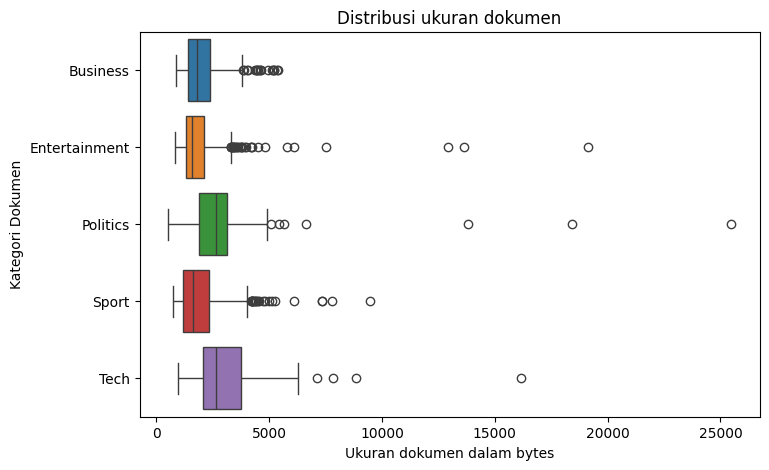

In [15]:
plt.figure(figsize=(8, 5))

sns.boxplot(data=meta_df, x="Ukuran_Doc", y="Doc_Kategori", palette="tab10", hue="Doc_Kategori", legend=False)
plt.title("Distribusi ukuran dokumen")
plt.xlabel("Ukuran dokumen dalam bytes")
plt.ylabel("Kategori Dokumen")

plt.show()

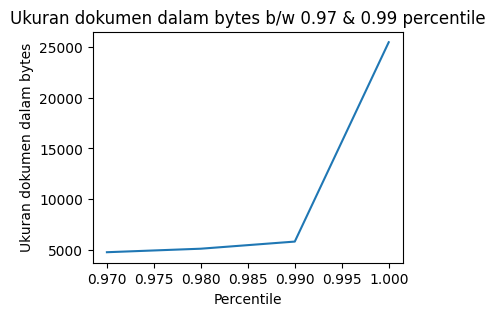

In [16]:
plot_elbow(0.97, 1, "Ukuran_Doc", meta_df, "Ukuran dokumen dalam bytes")

<b>Observations</b>

<ol>
    <li><b>99%</b> of documents have file size <b>less than ~6 KB.</b></li>
    <li><b>All documents</b> with file size <b>greater than 6 KB</b> can be considered as <b>outliers.</b></li>
</ol>

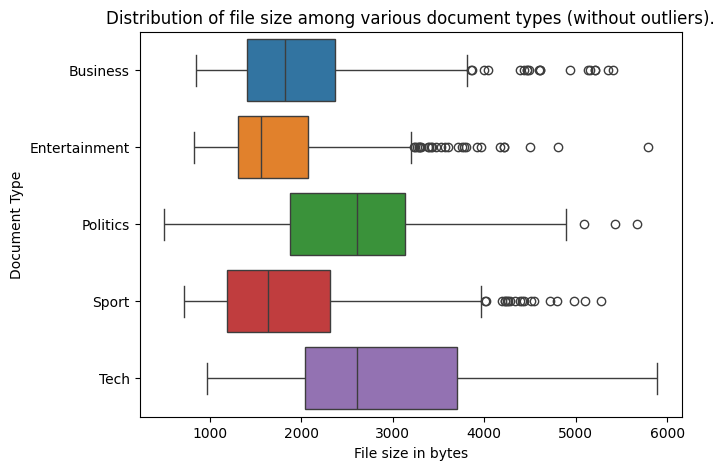

In [17]:
fltr = meta_df["Ukuran_Doc"] < 6_000

plt.figure(figsize=(7, 5))

sns.boxplot(data=meta_df[fltr], x="Ukuran_Doc", y="Doc_Kategori", palette="tab10", hue="Doc_Kategori", legend=False)
plt.title("Distribution of file size among various document types (without outliers).")
plt.xlabel("File size in bytes")
plt.ylabel("Document Type")

plt.show()

In [18]:
gte_6_KB = round(len(meta_df[~fltr]) / baris * 100, 1)
print(f"{gte_6_KB}% of documents are larger than 6 KB.")

0.9% of documents are larger than 6 KB.


<b>Observations</b>

<ol>
    <li>Distribution of FileSize features are overlapping for most of the document types.</li>
    <li>There is no visible pattern to differentiate various document types using only FileSize feature.</li>
    <li>Since only 0.9% of documents have file size greater than 6 KB, the outliers, they can be deleted later.</li>
    <li>Files of doc types tech and politics have larger file size compared to others.</li>
</ol>

In [19]:
fltr = meta_df["Ukuran_Doc"] > 6_000
outliers = meta_df.loc[fltr, "Doc_Kategori"].value_counts()
lost = np.round(np.divide(outliers.values, jum_kategori.values) * 100, 1)

display_as_table(
    headers=["Class label", "% of data lost per class"],
    rows=list(zip(jum_kategori.index, lost)),
    add_sl_no=True,
)

No.,Class label,% of data lost per class
1,Sport,1.2
2,Business,1.0
3,Politics,1.2
4,Tech,1.0
5,Entertainment,0.0


In [20]:
meta_df.drop(meta_df[fltr].index, inplace=True)

rows_wo, cols_wo = meta_df.shape  # wo :- Without outliers
print(f"Dataset contains {rows_wo} rows and {cols_wo} columns.")

Dataset contains 2205 rows and 5 columns.


In [63]:
# inp_text = """
# OMG!!!! This is line1.

# Is this really line 2????


# Some lengthy line -- to test text preprocessing. Oh! Text in "quotes" are not affected.
# Are these preprocessing steps enough?
# """

# print(preprocess_data(inp_text))

omg line really line lengthy line test text preprocessing oh text quote affected preprocessing step enough


In [42]:
meta_df.head(10)

,Doc_Kategori,Id_Doc,Ukuran_Doc,Path_Doc,DocCat
0,Tech,T_395,4914,dataset/tech/395.txt,0
1,Tech,T_396,6087,dataset/tech/396.txt,0
2,Tech,T_394,4895,dataset/tech/394.txt,0
3,Tech,T_392,2037,dataset/tech/392.txt,0
4,Tech,T_393,2867,dataset/tech/393.txt,0
5,Tech,T_391,4954,dataset/tech/391.txt,0
6,Tech,T_379,8828,dataset/tech/379.txt,0
7,Tech,T_380,1794,dataset/tech/380.txt,0
8,Tech,T_378,3422,dataset/tech/378.txt,0
9,Tech,T_381,3071,dataset/tech/381.txt,0


In [64]:
if os.path.exists(PARSED_TEXT_CSV):
    print("Loading parsed text data of documents from:", PARSED_TEXT_CSV)
    prsd_df = pd.read_csv(PARSED_TEXT_CSV)
else:
    parsed_data = []
    for doc_id, doc_path in tqdm(meta_df[["Id_Doc", "Path_Doc"]].values):

        # Read document as byte-file.
        with open(doc_path, "rb") as txt_f:
            ip_text = txt_f.read().decode("utf-8", errors="ignore").strip()  # Input txt

            if is_empty(ip_text):
                continue

            op_text = preprocess_data(ip_text)

            parsed_data.append([doc_id, len(op_text), op_text])

    # Convert parsed text from documents into a DataFrame.
    nama_kolom = ["Id_Doc", "Panjang_Doc", "Text_Doc"]

    # col_names = ["DocId", "DocTextlen", "DocText"]
    prsd_df = pd.DataFrame(parsed_data, columns=nama_kolom)

    # Save DataFrame as CSV file for future use.
    prsd_df.to_csv(PARSED_TEXT_CSV, index=False, na_rep="")
    print("Parsed text saved to:", PARSED_TEXT_CSV)

prsd_df.head()

100%|██████████| 2225/2225 [00:29<00:00, 74.59it/s]


Parsed text saved to: doc_parsed_text1.csv


,Id_Doc,Panjang_Doc,Text_Doc
0,T_395,3125,cebit fever take hanover thousand product ten ...
1,T_396,4316,new console promise big problem making game fu...
2,T_394,3145,tv future phone line internet tv talked since ...
3,T_392,1423,broadband fuel online expression fast web acce...
4,T_393,1806,savvy searcher fail spot ad internet search en...


In [49]:
prsd_df.head()

,Id_Doc,Panjang_Doc,Text_Doc
0,T_395,3125,cebit fever take hanover thousand product ten ...
1,T_396,4316,new console promise big problem making game fu...
2,T_394,3145,tv future phone line internet tv talked since ...
3,T_392,1424,broadband fuel online expression fast web acce...
4,T_393,1806,savvy searcher fail spot ad internet search en...


In [50]:
x_train, x_test,y_train,y_test = train_test_split(prsd_df['Text_Doc'],meta_df['Doc_Label'],test_size=0.10, shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2002,)
(223,)
(2002,)
(223,)


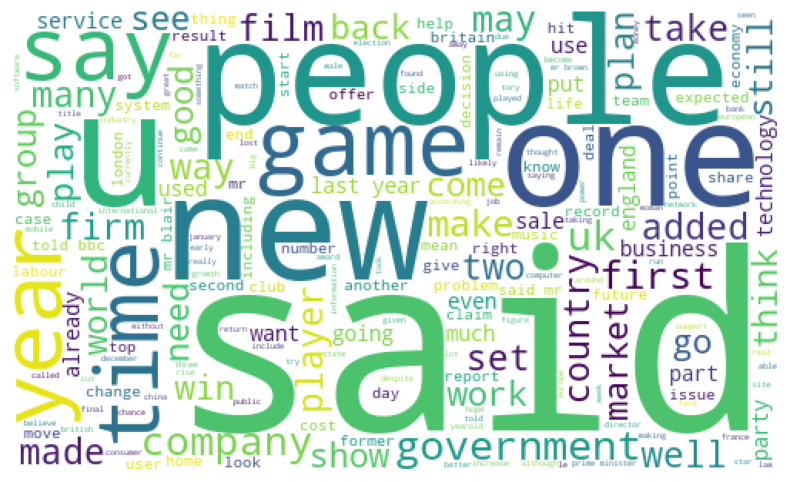

In [60]:
generate_wordcloud(prsd_df,"Text_Doc")

In [55]:
tfidf = TfidfVectorizer(ngram_range=(1,5),max_df=0.95, max_features=15000)

tfidf_train = tfidf.fit_transform(x_train)
tfidf_test = tfidf.transform(x_test)

In [56]:
tfidf_train.A.shape

(2002, 15000)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Confusion Matrix:
[[38  1  1  1  0]
 [ 0 39  0  0  0]
 [ 2  2 38  0  1]
 [ 0  4  1 43  1]
 [ 0  0  0  1 50]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        41
           1       0.85      1.00      0.92        39
           2       0.95      0.88      0.92        43
           3       0.96      0.88      0.91        49
           4       0.96      0.98      0.97        51

    accuracy                           0.93       223
   macro avg       0.93      0.93      0.93       223
weighted avg       0.94      0.93      0.93       223



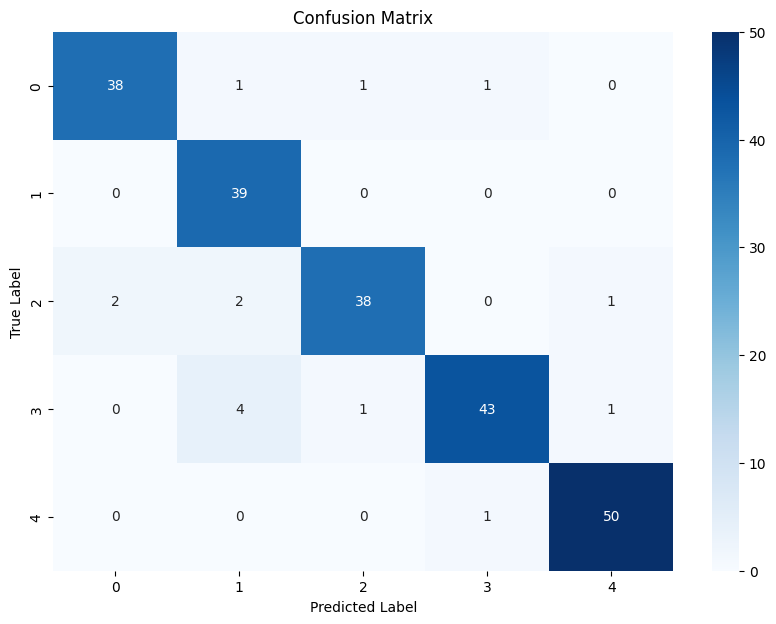

In [58]:
from sklearn.neighbors import KNeighborsClassifier
# Langkah tambahan untuk pemodelan KNN dan Confusion Matrix

# 1. Inisialisasi dan latih model KNN
knn = KNeighborsClassifier(n_neighbors=5)  # Anda dapat mengubah jumlah tetangga sesuai kebutuhan
knn.fit(tfidf_train, y_train)

# 2. Prediksi menggunakan model KNN
y_pred = knn.predict(tfidf_test)

# 3. Hitung Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# 4. Cetak Confusion Matrix dan Classification Report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualisasi Confusion Matrix menggunakan heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()